In [1]:
import sys

sys.path.append("..") if ".." not in sys.path else print("Already exists")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from torch.utils.data import WeightedRandomSampler
from torchvision import models
from torchvision import transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
from utils.dataset import get_dataloader
from utils.plots import EvaluationPlots
from utils.training import TrainingInterface, print_total_params, train_network

# WeightedRandomSampling

### Initiate Dataloaders

In [2]:
train_transformations = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.RandAugment(num_ops=3, magnitude=7),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transformations = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

inverse_transforms = transforms.Compose(
    [
        transforms.Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
    ]
)

In [3]:
df = pd.read_csv("../data/labels.csv")
df.head(2)

,image,set,label
0,100161900.png,test,Rost/Strassenrost
1,100184900.png,train,Rost/Strassenrost


In [4]:
train = df[df["set"] == "train"].sample(frac=1).reset_index(drop=True)

<AxesSubplot:>

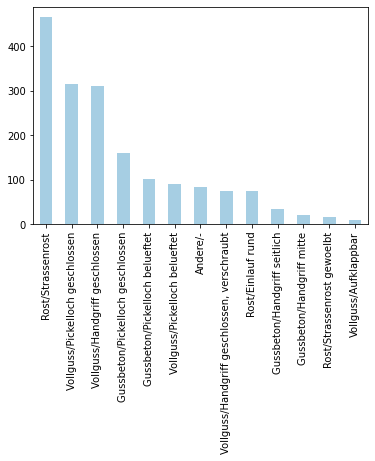

In [5]:
train["label"].value_counts().plot(kind="bar")

In [6]:
# Get the inverse label weight
label_counts = train.shape[0] / (
    train["label"].unique().shape[0] * train["label"].value_counts()
)
label_counts

Rost/Strassenrost                               0.291481
Vollguss/Pickelloch geschlossen                 0.428919
Vollguss/Handgriff geschlossen                  0.437221
Gussbeton/Pickelloch geschlossen                0.847115
Gussbeton/Pickelloch belueftet                  1.315907
Vollguss/Pickelloch belueftet                   1.505983
Andere/-                                        1.594570
Vollguss/Handgriff geschlossen, verschraubt     1.783401
Rost/Einlauf rund                               1.807179
Gussbeton/Handgriff seitlich                    3.872527
Gussbeton/Handgriff mitte                       6.160839
Rost/Strassenrost gewoelbt                      8.471154
Vollguss/Aufklappbar                           15.059829
Name: label, dtype: float64

In [7]:
train["weight"] = train["label"].apply(lambda x: label_counts[x])
train.head(2)

,image,set,label,weight
0,100125800.png,train,Gussbeton/Pickelloch belueftet,1.315907
1,100174800.png,train,Vollguss/Pickelloch geschlossen,0.428919


## Hyperparams

In [8]:
# Logger
import wandb
run = wandb.init(project="manhole_cover_classification", entity="sifi")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sifi (use `wandb login --relogin` to force relogin)


In [9]:
####### Hyperparameters ########
NAME = 'resnet18_pretrained_rws'

## Sampler
WEIGHTED_SAMPLER = True
SAMPLER_NUM_SAMPLES = 2000
SAMPLER_REPLACEMENT = True

## General
WORKERS = 20
BATCH_SIZE = 32

## Model
PRETRAINED = True

## Training
LR = .00005
WEIGHT_DECAY = .1
WEIGHTED_LOSS = False
EPOCHS = 120

In [10]:
wandb.config = {
    'MODEL_NAME': NAME, 
    'WEIGHTED_SAMPLER': WEIGHTED_SAMPLER,
    'SAMPLER_NUM_SAMPLES': SAMPLER_NUM_SAMPLES,
    'SAMPLER_REPLACEMENT': SAMPLER_REPLACEMENT,
    'WORKERS': WORKERS,
    'BATCH_SIZE': BATCH_SIZE,
    'PRETRAINED': PRETRAINED,
    'LR': LR,
    'WEIGHT_DECAY': WEIGHT_DECAY,
    'WEIGHTED_LOSS': WEIGHTED_LOSS,
    'EPOCHS' : EPOCHS
}

In [11]:
if WEIGHTED_SAMPLER:
    sampler = WeightedRandomSampler(
        weights=train["weight"].to_numpy(),
        num_samples=SAMPLER_NUM_SAMPLES,
        replacement=SAMPLER_REPLACEMENT,
    )

In [12]:
if WEIGHTED_SAMPLER:
    dataloader_train = get_dataloader(
        root_dir="../data/train/",
        df=train,
        fp_label_translator="../utils/dataset/label_translate.pkl",
        transformations=train_transformations,
        batch_size=BATCH_SIZE,
        workers=WORKERS,
        pin_memory=True,
        shuffle=False,
        sampler=sampler,
    )
else:
    dataloader_train = get_dataloader(
        root_dir="../data/train/",
        df=train,
        fp_label_translator="../utils/dataset/label_translate.pkl",
        transformations=train_transformations,
        batch_size=BATCH_SIZE,
        workers=WORKERS,
        pin_memory=True,
        shuffle=True,
    )
dataloader_val = get_dataloader(
    root_dir="../data/val/",
    df=df[df["set"] == "val"].reset_index(drop=True),
    fp_label_translator="../utils/dataset/label_translate.pkl",
    transformations=test_transformations,
    batch_size=BATCH_SIZE,
    workers=12,
    pin_memory=True,
    shuffle=True,
)
dataloader_test = get_dataloader(
    root_dir="../data/test/",
    df=df[df["set"] == "test"].reset_index(drop=True),
    fp_label_translator="../utils/dataset/label_translate.pkl",
    transformations=test_transformations,
    batch_size=BATCH_SIZE,
    workers=WORKERS,
    pin_memory=True,
    shuffle=True,
)

In [13]:
assert dataloader_train.dataset.label_dict == dataloader_val.dataset.label_dict
assert dataloader_val.dataset.label_dict == dataloader_test.dataset.label_dict

### Check Dataloader Batch

In [14]:
# Plot batch
check_batch = False

plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(12, 20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


if check_batch:
    for loader in [dataloader_train, dataloader_val, dataloader_test]:
        img, labels = next(iter(loader))
        assert img.shape[0] == BATCH_SIZE
        assert len(labels) == BATCH_SIZE
        print("-- Check passed --")

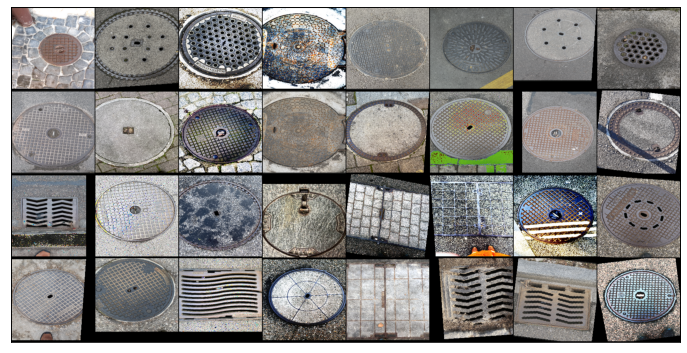

In [15]:
image, label = next(iter(dataloader_train))
show(make_grid(inverse_transforms(image)))

In [16]:
all_labels = np.array([])
for batch in tqdm(dataloader_train):
    _, label = batch
    all_labels = np.append(all_labels, label.tolist())

  0%|          | 0/63 [00:00<?, ?it/s]

In [17]:
all_labels = [dataloader_train.dataset.label_dict_r[lab] for lab in all_labels]

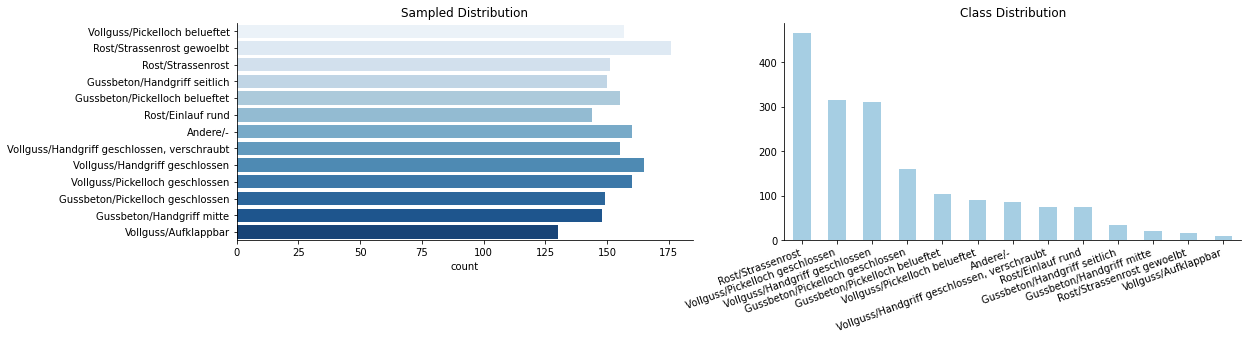

In [18]:
fig, ax = plt.subplots(figsize=(18, 4))

plt.subplot(1, 2, 1)
p = sns.countplot(y=all_labels, palette="Blues")
p.set_title("Sampled Distribution")
sns.despine()
plt.subplot(1, 2, 2)
p = train["label"].value_counts().plot(kind="bar")
p.set_xticklabels(p.get_xticklabels(), rotation=20, ha="right")
p.set_title("Class Distribution")
sns.despine()
plt.show()

## ResNet18

In [19]:
resnet_ = models.resnet18(pretrained=PRETRAINED, progress=True)

In [20]:
if PRETRAINED:
    for param in resnet_.parameters():
        param.requires_grad = False

    # Replace fc
    resnet_.fc = nn.Linear(512, len(dataloader_train.dataset.label_dict.keys()))

    # Enable grad
    resnet_.fc.weight.requires_grad = True
    resnet_.fc.bias.requires_grad = True

    # check
    for name, param in resnet_.named_parameters():
        if param.requires_grad:
            print("Requires Grad:", name)

Requires Grad: fc.weight
Requires Grad: fc.bias


In [21]:
resnet = TrainingInterface(
    model=resnet_, 
    name=NAME,
    history=True, 
    writer=wandb
)

Found Existing History Folder. Removing all Files: train_history_resnet18_pretrained_rws


In [22]:
if WEIGHTED_LOSS:
    train.groupby("label").first()["weight"]
    ce_weights = [
        train.loc[train["label"] == key, "weight"].iloc[0]
        for key in dataloader_train.dataset.label_dict.keys()
    ]
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(ce_weights))
    optimizer = optim.Adam(
        resnet.model.parameters(), 
        lr=LR, 
        weight_decay=WEIGHT_DECAY
    )
else:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        resnet.model.parameters(), 
        lr=LR, 
        weight_decay=WEIGHT_DECAY
    )

In [23]:
resnet.train(
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=EPOCHS,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    verbose=True,
)

  0%|          | 0/7560 [00:00<?, ?it/s]

Epoch 1/120: [Train-Loss = 170.013] || [Validation-Loss = 17.869]
Epoch 2/120: [Train-Loss = 160.421] || [Validation-Loss = 16.512]
Epoch 3/120: [Train-Loss = 152.486] || [Validation-Loss = 15.822]
Epoch 4/120: [Train-Loss = 145.444] || [Validation-Loss = 15.206]
Epoch 5/120: [Train-Loss = 138.713] || [Validation-Loss = 14.336]
Epoch 6/120: [Train-Loss = 133.228] || [Validation-Loss = 14.134]
Epoch 7/120: [Train-Loss = 127.897] || [Validation-Loss = 13.235]
Epoch 8/120: [Train-Loss = 124.279] || [Validation-Loss = 12.918]
Epoch 9/120: [Train-Loss = 120.463] || [Validation-Loss = 12.741]
Epoch 10/120: [Train-Loss = 114.101] || [Validation-Loss = 12.345]
Epoch 11/120: [Train-Loss = 112.533] || [Validation-Loss = 12.05]
Epoch 12/120: [Train-Loss = 109.747] || [Validation-Loss = 11.49]
Epoch 13/120: [Train-Loss = 105.801] || [Validation-Loss = 11.524]
Epoch 14/120: [Train-Loss = 105.199] || [Validation-Loss = 11.007]
Epoch 15/120: [Train-Loss = 100.505] || [Validation-Loss = 11.071]
Epoch 

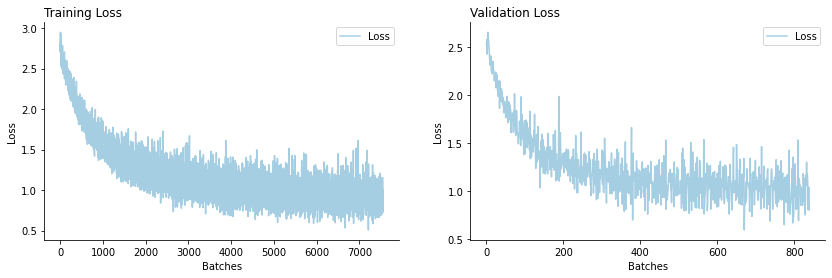

In [24]:
EvaluationPlots.plot_train_val_loss(resnet.train_loss, resnet.val_loss)

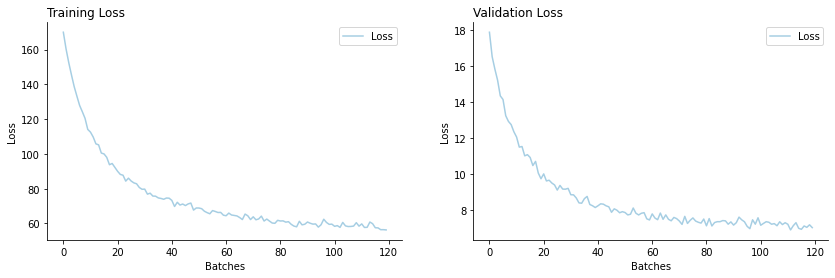

In [25]:
EvaluationPlots.plot_train_val_loss(resnet.train_epoch_loss, resnet.val_epoch_loss)

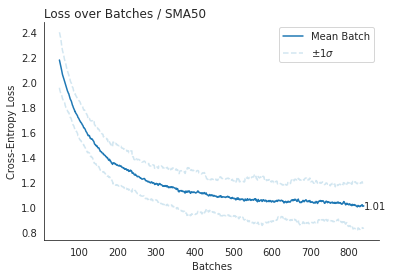

In [26]:
EvaluationPlots.loss_sma(loss=resnet.val_loss)

In [27]:
res = resnet.predict(dataloader_test, return_images=False, return_prob=False)

Calculate Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

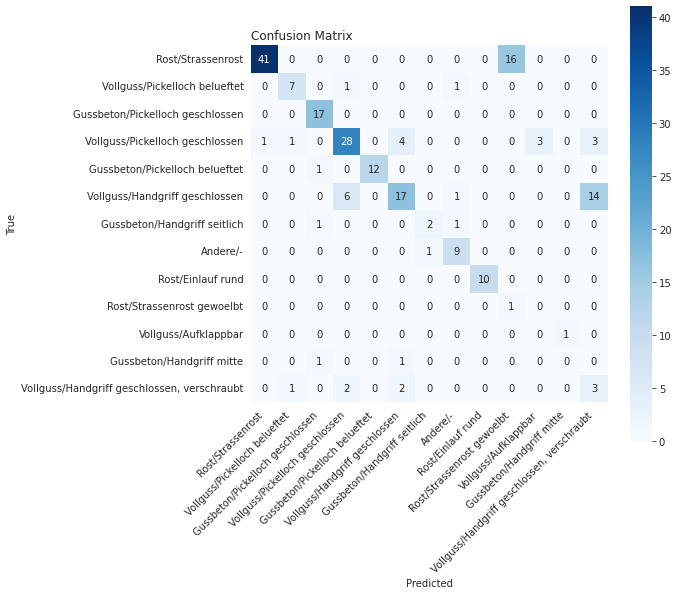

In [28]:
EvaluationPlots.plot_confusion_matrix(
    res[0], res[1], dataloader_test.dataset.label_dict_r
)

In [29]:
def evaluate_max_score(model, epoch_space):
    scores = {"test": [], "train": []}
    for ep in tqdm(epoch_space):
        model.load_from_history(epoch=ep, inplace=True)
        metrics = model.calculate_metrics(
            dataloader_train=dataloader_train,
            dataloader_test=dataloader_test,
            metric_funcs=[precision_score, recall_score, f1_score],
            disable_pbar=True,
            average="macro",
            zero_division=0,
        )
        scores["train"].append(metrics["train"]["f1_score"])
        scores["test"].append(metrics["test"]["f1_score"])

    return scores

def plot_max_score(scores, epoch_space):
    sns.set_style('whitegrid')
    tmp = pd.DataFrame.from_dict(scores)
    max_arg = epoch_space[np.argmax(tmp["test"])]
    p = sns.lineplot(x=epoch_space, y=tmp["train"], label="train")
    p = sns.lineplot(x=epoch_space, y=tmp["test"], label="test")
    p.vlines(x=max_arg, ymin=0, ymax=1, linestyles="--", color="grey")
    p.set_title('Evaluation Score in Backrun')
    plt.text(x=max_arg + 2, y=0, s=f"Epoch {max_arg}")
    sns.despine()
    plt.show()

In [30]:
epoch_space = np.linspace(start=10, stop=EPOCHS, num=EPOCHS//2, dtype=int)

In [31]:
scores = evaluate_max_score(resnet, epoch_space)

  0%|          | 0/60 [00:00<?, ?it/s]

Replaced self.model -> epoch 10
Replaced self.model -> epoch 11
Replaced self.model -> epoch 13
Replaced self.model -> epoch 15
Replaced self.model -> epoch 17
Replaced self.model -> epoch 19
Replaced self.model -> epoch 21
Replaced self.model -> epoch 23
Replaced self.model -> epoch 24
Replaced self.model -> epoch 26
Replaced self.model -> epoch 28
Replaced self.model -> epoch 30
Replaced self.model -> epoch 32
Replaced self.model -> epoch 34
Replaced self.model -> epoch 36
Replaced self.model -> epoch 37
Replaced self.model -> epoch 39
Replaced self.model -> epoch 41
Replaced self.model -> epoch 43
Replaced self.model -> epoch 45
Replaced self.model -> epoch 47
Replaced self.model -> epoch 49
Replaced self.model -> epoch 51
Replaced self.model -> epoch 52
Replaced self.model -> epoch 54
Replaced self.model -> epoch 56
Replaced self.model -> epoch 58
Replaced self.model -> epoch 60
Replaced self.model -> epoch 62
Replaced self.model -> epoch 64
Replaced self.model -> epoch 65
Replaced

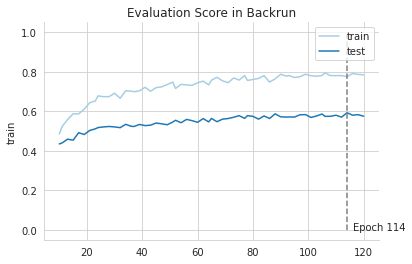

In [32]:
plot_max_score(scores, epoch_space=epoch_space)

114

In [39]:
resnet.load_from_history(epoch=epoch_space[np.argmax(scores['test'])], inplace=True)

Replaced self.model -> epoch 114


In [40]:
metrics = resnet.calculate_metrics(
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    metric_funcs=[precision_score, recall_score, f1_score],
    average="macro",
)
metrics

Predictions Train-Set:   0%|          | 0/63 [00:00<?, ?it/s]

Predictions Test-Set:   0%|          | 0/7 [00:00<?, ?it/s]

{'train': {'precision_score': 0.7782387155525486,
  'recall_score': 0.7783356775301234,
  'f1_score': 0.7769559323355945},
 'test': {'precision_score': 0.6063754471649209,
  'recall_score': 0.6594449634935464,
  'f1_score': 0.5927608413724156}}

In [41]:
res = resnet.predict(dataloader_test, return_images=False, return_prob=True)

Calculate Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

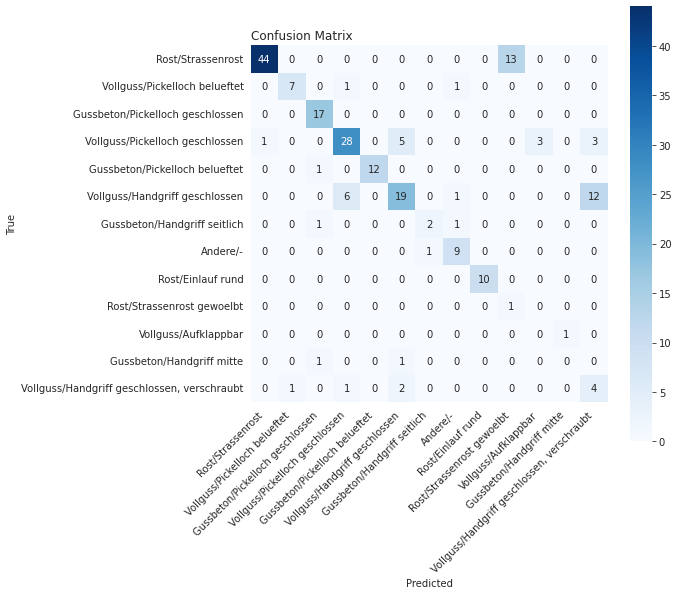

In [42]:
EvaluationPlots.plot_confusion_matrix(
    res[0], res[1], dataloader_test.dataset.label_dict_r
)

In [52]:
run.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_f1_score,▁▁▂▄▄▄▅▅▅▅▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇███
test_precision_score,▁▂▃▄▅▅▅▆▅▆▆▅▅▆▆▇▆▇▆▆▆▇▇█▇█▇▇▇▇██▇█▇▇▇███
test_recall_score,▁▁▂▃▃▃▄▄▃▄▄▄▄▄▄▅▄▄▄▇▅▇▅▅▇▇▇▅▇▇▇▆▅█▆█▅█▆█
train_batch_loss,█▆▆▅▄▄▄▃▃▃▂▂▃▂▂▄▂▂▂▂▁▃▃▂▂▂▃▂▂▂▂▂▂▃▂▃▂▁▁▂
train_epoch_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_f1_score,▁▂▃▃▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇█▇██▇█████████
train_precision_score,▁▂▃▄▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇█▇██▇█████████
train_recall_score,▁▂▃▃▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇█▇██▇█████████
val_batch_loss,█▇▆▅▄▄▃▄▃▃▃▃▃▂▄▂▄▃▂▃▁▃▂▂▁▂▂▁▁▃▂▁▃▃▂▂▂▁▂▁
val_epoch_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## Source

https://www.maskaravivek.com/post/pytorch-weighted-random-sampler/